In [ ]:
import jax
import jax.numpy as jnp
from jax import random, grad, jit, vmap, lax
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import json
import os
import datetime
import pandas as pd
import math
import time

In [ ]:
EXP_NAME = "anisotropic_annealing_experiments"
SAVE_DIR = f"./results/{EXP_NAME}_{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}"
os.makedirs(SAVE_DIR, exist_ok=True)

# Set seeds
GLOBAL_SEED = 42
key = jax.random.PRNGKey(GLOBAL_SEED)
np.random.seed(GLOBAL_SEED)


# Global Hyperparameters 
GLOBAL_CONFIG = {
    "N_POINTS": 4,
    "DIM": 3,
    "POSITIVE_PAIRS": [(0, 1), (2, 3)],  # toy contrastive pairs
    "dt": 0.01,  # discretization step
    "max_steps": 5000000,
    "success_threshold": 1e-4,
}
with open(os.path.join(SAVE_DIR, "config.json"), "w") as f:
    json.dump(GLOBAL_CONFIG, f, indent=4)


N_POINTS = GLOBAL_CONFIG["N_POINTS"]
DIM = GLOBAL_CONFIG["DIM"]
POSITIVE_PAIRS = jnp.array(GLOBAL_CONFIG["POSITIVE_PAIRS"])
DT = GLOBAL_CONFIG["dt"]
SUCCESS_THRESHOLD = GLOBAL_CONFIG["success_threshold"]

# Potential and projection functions

@jit
def U0(Z):
    """Limiting potential U0(Z)."""
    Z_norm = Z / jnp.linalg.norm(Z, axis=1, keepdims=True)
    sim_matrix = jnp.dot(Z_norm, Z_norm.T)

    def potential_for_pair(pair):
        i, j = pair[0], pair[1]
        pos_sim = sim_matrix[i, j]

        # mask to ignore positives/self
        mask = jnp.ones_like(sim_matrix[i, :]).at[jnp.array([i, j])].set(-jnp.inf)
        hardest_neg_i = jnp.max(sim_matrix[i, :] + mask)
        hardest_neg_j = jnp.max(sim_matrix[j, :] + mask)

        energy = (-pos_sim + hardest_neg_i) + (-pos_sim + hardest_neg_j)
        return energy

    total_energy = jnp.sum(jax.lax.map(potential_for_pair, POSITIVE_PAIRS))
    return total_energy / (2 * len(POSITIVE_PAIRS))


grad_U0 = jit(grad(U0))

@jit
def renormalize(Z):
    """Project back to unit sphere (row-wise)."""
    return Z / jnp.linalg.norm(Z, axis=1, keepdims=True)


@jit
def get_projection_matrix(point):
    """Projection to tangent space at a point on the sphere."""
    return jnp.eye(DIM) - jnp.outer(point, point)


batch_get_projection_matrix = vmap(get_projection_matrix)

# SDE Step Functions

def isotropic_sde_step(Z, t_idx, c, dt, key):
    """One isotropic annealing SDE step."""
    t = t_idx * dt
    beta_t = c * jnp.log(t + 1.0)
    beta_t = jnp.maximum(beta_t, 1e-6)

    step_key = jax.random.fold_in(key, t_idx)
    dW_ambient = jax.random.normal(step_key, shape=Z.shape)
    projection_matrices = batch_get_projection_matrix(Z)
    dW_tangent = jnp.einsum("bij,bj->bi", projection_matrices, dW_ambient)

    drift = -grad_U0(Z) * dt
    noise = dW_tangent * jnp.sqrt(2 * dt / beta_t)

    return renormalize(Z + drift + noise), None


def anisotropic_sde_step(Z, t_idx, c, dt, key, A):
    """One anisotropic annealing SDE step with diffusion A."""
    t = t_idx * dt
    beta_t = c * jnp.log(t + 1.0)
    beta_t = jnp.maximum(beta_t, 1e-6)
    B = jnp.sqrt(A)

    step_key = jax.random.fold_in(key, t_idx)
    dW_ambient = jax.random.normal(step_key, shape=Z.shape)

    # Use B (the matrix sqrt) instead of A
    dW_aniso = jnp.einsum("ij,bj->bi", B, dW_ambient)

    projection_matrices = batch_get_projection_matrix(Z)
    dW_tangent = jnp.einsum("bij,bj->bi", projection_matrices, dW_aniso)

    drift = -grad_U0(Z) * dt
    noise = dW_tangent * jnp.sqrt(2 * dt / beta_t)

    return renormalize(Z + drift + noise), None


def fixed_temp_sde_step(Z, t_idx, beta_fixed, dt, key, B):
    step_key = jax.random.fold_in(key, t_idx)
    dW_ambient = jax.random.normal(step_key, shape=Z.shape)
    dW_aniso = jnp.einsum("ij,bj->bi", B, dW_ambient)
    projection_matrices = batch_get_projection_matrix(Z)
    dW_tangent = jnp.einsum("bij,bj->bi", projection_matrices, dW_aniso)
    drift = -grad_U0(Z) * dt
    noise = dW_tangent * jnp.sqrt(2 * dt / beta_fixed)
    return renormalize(Z + drift + noise), None

print(f"Base framework initialized. Saving results to: {SAVE_DIR}")

# Generic Simulation Harness

def simulate_one_run_iso(key, c, n_steps, dt):
    """Simulate one isotropic run."""
    Z = renormalize(jax.random.normal(key, shape=(N_POINTS, DIM)))

    def step_fn(Z, t_idx):
        return isotropic_sde_step(Z, t_idx, c, dt, key)

    final_Z, _ = jax.lax.scan(step_fn, Z, jnp.arange(n_steps))
    return final_Z

def simulate_one_run_aniso(key, c, n_steps, dt, A):
    """Simulate one anisotropic run with diffusion matrix A."""
    Z = renormalize(jax.random.normal(key, shape=(N_POINTS, DIM)))

    def step_fn(Z, t_idx):
        return anisotropic_sde_step(Z, t_idx, c, dt, key, A)

    final_Z, _ = jax.lax.scan(step_fn, Z, jnp.arange(n_steps))
    return final_Z

def simulate_one_run_fixed(key, beta_fixed, n_steps, dt, B):
    Z = renormalize(jax.random.normal(key, shape=(N_POINTS, DIM)))
    def step_fn(Z, t_idx):
        return fixed_temp_sde_step(Z, t_idx, beta_fixed, dt, key, B)
    final_Z, _ = jax.lax.scan(step_fn, Z, jnp.arange(n_steps))
    return final_Z

batch_simulate_iso = jit(
    vmap(simulate_one_run_iso, in_axes=(0, None, None, None)),
    static_argnums=(2,)
)

batch_simulate_aniso = jit(
    vmap(simulate_one_run_aniso, in_axes=(0, None, None, None, None)),
    static_argnums=(2,)
)

batch_simulate_fixed = jit(
    vmap(simulate_one_run_fixed, in_axes=(0, None, None, None, None)),
    static_argnums=(2,)
)


# Wilson Score Interval Function

def wilson_score_interval(p, n, z=1.96):
    """Calculates the Wilson score interval for a binomial proportion."""
    if n == 0 or p is None: return (0, 1)
    p = float(p); n = int(n)
    numerator = p + z**2 / (2 * n); denominator = 1 + z**2 / n
    term = z * np.sqrt(p * (1 - p) / n + z**2 / (4 * n**2))
    lower = (numerator - term) / denominator; upper = (numerator + term) / denominator
    return (max(0, lower), min(1, upper))

Base framework initialized. Saving results to: ./results/anisotropic_annealing_experiments_20251001_113939


## Experiment 1: Annealing Rate Sweep

In [ ]:
def compute_min_c(beta_target, T_max):
    return beta_target / math.log(T_max + 1.0)

def build_default_c_grid(beta_target, dt, max_steps, n_coarse=30, n_dense=30):
    """
    Build a practical default c grid that avoids trivially truncated c values.
    """
    T_max = max_steps * dt
    c_min_feasible = compute_min_c(beta_target, T_max)
    # guard
    c_min = max(0.5, c_min_feasible * 0.8)  # slightly below feasible to allow a few truncated points
    c_hi = 200.0
    coarse = np.logspace(np.log10(c_min), np.log10(c_hi), n_coarse)
    dense = np.linspace(max(c_min, 1.0), min(25.0, c_hi), n_dense)
    c_vals = np.unique(np.concatenate([coarse, dense]))
    c_vals = np.sort(c_vals)
    return c_vals, c_min_feasible

def run_experiment_1(
    beta_target=40.0,
    c_values=None,
    n_runs_base=1024,
    min_runs=64,
    max_runs=2048,
    dt=GLOBAL_CONFIG["dt"],
    max_steps=GLOBAL_CONFIG["max_steps"],
    success_threshold=GLOBAL_CONFIG["success_threshold"],
    A_aniso=jnp.diag(jnp.array([10.0, 10.0, 0.01])),
    save_dir=SAVE_DIR,
    verbose=True
):
    """
    Experiment 1: Sweep annealing rate c and estimate success probability for isotropic and anisotropic SDEs.
    """
    global key

    # Make grid if none provided
    if c_values is None:
        c_values, c_min_feasible = build_default_c_grid(beta_target, dt, max_steps)
        if verbose:
            print(f"[Info] Auto c-grid built. c_min_feasible ≈ {c_min_feasible:.4f}, using {len(c_values)} c values.")
    else:
        c_values = np.asarray(c_values)
        T_max = max_steps * dt
        c_min_feasible = compute_min_c(beta_target, T_max)
        if verbose:
            print(f"[Info] Using provided c_values (len={len(c_values)}). c_min_feasible ≈ {c_min_feasible:.4f}")

    results = []
    meta = {
        "GLOBAL_SEED": int(GLOBAL_SEED),
        "N_POINTS": int(N_POINTS),
        "DIM": int(DIM),
        "dt": float(dt),
        "max_steps": int(max_steps),
        "beta_target": float(beta_target),
        "success_threshold": float(success_threshold),
        "A_aniso_diag": list(map(float, jnp.diag(A_aniso))),
        "n_runs_base": int(n_runs_base),
        "min_runs": int(min_runs),
        "max_runs": int(max_runs),
        "timestamp": datetime.datetime.now().isoformat()
    }

    out_json = os.path.join(save_dir, "experiment1_results.json")
    out_plot = os.path.join(save_dir, "experiment1_plot.png")

    pbar = tqdm(c_values, desc="Experiment 1 c-sweep")
    for c in pbar:
        # compute required continuous time and steps to reach beta_target
        # Check for potential overflow BEFORE calling math.exp()
        exponent = beta_target / float(c)
        if exponent > 709:  # math.exp(709.78) is roughly the max float64
            required_steps = max_steps
            truncated = True
            T_final = float('inf')
        else:
            T_final = math.exp(exponent) - 1.0
            required_steps = int(min(math.ceil(T_final / dt), max_steps))
            truncated = (T_final / dt) > max_steps

        # heuristic adapt number of runs by cost
        # scale = min(1.0, max_steps / required_steps)
        if required_steps <= 0:
            scale = 1.0
        else:
            scale = min(1.0, float(max_steps) / float(required_steps))
        n_runs = int(max(min_runs, min(max_runs, round(n_runs_base * scale))))

        start_key_int = int(key[0]) if hasattr(key, "shape") else int(key)  # key is uint32 array
        keys = jax.random.split(key, n_runs + 1)
        run_keys = keys[:-1]
        key = keys[-1]  # update global key for next loop

        # Run isotropic
        try:
            final_Zs_iso = batch_simulate_iso(run_keys, c, required_steps, dt)
            energies_iso = np.asarray(vmap(U0)(final_Zs_iso))
            prob_iso = float(np.mean(energies_iso < success_threshold))
            frac_never_iso = float(np.mean(energies_iso >= success_threshold))
        except Exception as e:
            print(f"[Error] isotropic run failed for c={c}: {e}")
            prob_iso = None
            frac_never_iso = None

        # Run anisotropic
        try:
            final_Zs_aniso = batch_simulate_aniso(run_keys, c, required_steps, dt, A_aniso)
            energies_aniso = np.asarray(vmap(U0)(final_Zs_aniso))
            prob_aniso = float(np.mean(energies_aniso < success_threshold))
            frac_never_aniso = float(np.mean(energies_aniso >= success_threshold))
        except Exception as e:
            print(f"[Error] anisotropic run failed for c={c}: {e}")
            prob_aniso = None
            frac_never_aniso = None

        beta_reached = float(c * math.log(required_steps * dt + 1.0))

        entry = {
            "c": float(c),
            "required_steps": int(required_steps),
            "truncated": bool(truncated),
            "n_runs": int(n_runs),
            "start_key_int": int(start_key_int),
            "beta_target": float(beta_target),
            "beta_reached": beta_reached,
            "prob_iso": prob_iso,
            "prob_aniso": prob_aniso,
            "frac_never_iso": frac_never_iso,
            "frac_never_aniso": frac_never_aniso,
            "success_threshold": float(success_threshold)
        }
        results.append(entry)

        # incremental save (meta + results)
        with open(out_json, "w") as f:
            json.dump({"meta": meta, "results": results}, f, indent=2)

        pbar.set_description(f"c={c:.3g}, steps={required_steps}, runs={n_runs}")
        time.sleep(0.01)

    # Make a quick debugging plot (only plot non-None results)
    cs = np.array([r["c"] for r in results if r["prob_iso"] is not None])
    probs_iso = np.array([r["prob_iso"] for r in results if r["prob_iso"] is not None])
    probs_aniso = np.array([r["prob_aniso"] for r in results if r["prob_aniso"] is not None])

    plt.style.use("seaborn-v0_8-whitegrid")
    plt.figure(figsize=(10, 6))
    plt.plot(cs, probs_iso, "o-", label="Isotropic")
    plt.plot(cs, probs_aniso, "s-", label=f"Anisotropic (diag={meta['A_aniso_diag']})")
    plt.axhline(y=0.5, color="grey", linestyle="--", alpha=0.7, label="50% Threshold")
    plt.xscale("log")
    plt.ylim(-0.05, 1.05)
    plt.xlabel("Annealing Rate c (log scale)")
    plt.ylabel("Success Probability")
    plt.title(f"Experiment 1: Convergence Probability vs Annealing Rate (beta_target={beta_target})")
    plt.legend()
    plt.tight_layout()
    plt.savefig(out_plot, dpi=300)
    plt.show()

    print(f"[Done] Results saved to {out_json} and {out_plot}")
    return results

In [ ]:
A_small = jnp.diag(jnp.array([1.,1.,0.1]))
A_large = jnp.diag(jnp.array([20.0, 20.0, 10.0]))

run_experiment_1(
    beta_target=10.0,
    n_runs_base=1024,
    A_aniso=A_small,
    max_runs=2048,
    min_runs=128,
    save_dir='./results/aniso_small',
)
run_experiment_1(
    beta_target=10.0,
    n_runs_base=1024,
    A_aniso=A_large,
    max_runs=2048,
    min_runs=128,
    save_dir='./results/aniso_large',
)

# c_values_slow = np.logspace(-1, 2, 20) # 20 points from c=0.1 to c=10
# run_experiment_1(
#     beta_target=100.0,  # The new, higher target
#     c_values=c_values_slow,
#     n_runs_base=2048,  # Use a high number of runs for tigher bounds
#     max_steps=100000,  # Increase max_steps to allow the schedule to complete
#     A_aniso=A_large,
# )

### Experiment 1 plotting

--- Loading and processing annealed results ---

--- Loading pre-computed fixed-beta results from: anisotropic_experiments\experiment1\fixed_beta_10_results.json ---

--- Generating final plot ---

[Success] Final plot saved to ./results/final_figures\figure_1a_final_beta10.png


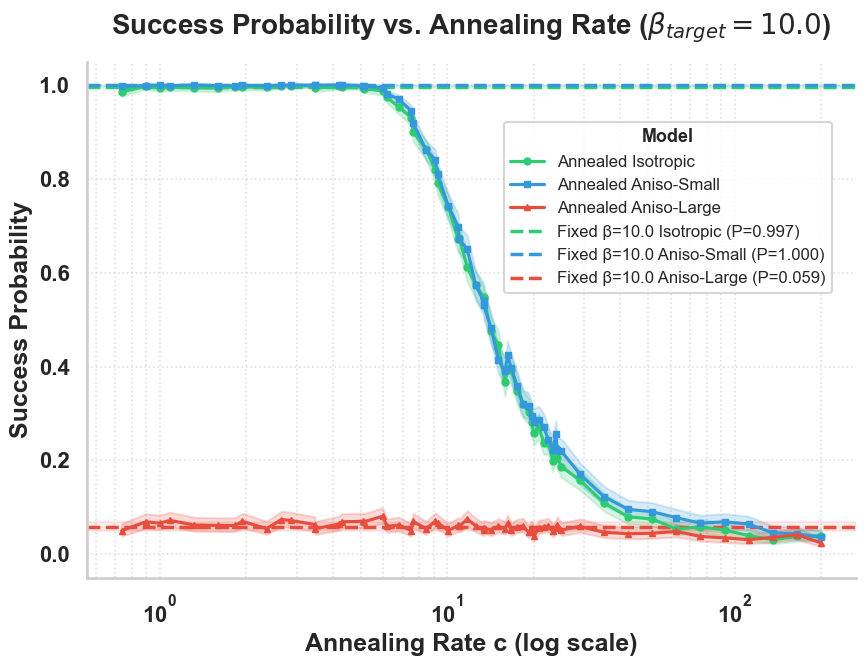

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from scipy.stats import norm
import seaborn as sns


def create_figure_1a(
    saved_small_aniso_path,
    saved_large_aniso_path,
    save_dir,
    precomputed_fixed_beta_path=None,
    beta_fixed=10.0,
    n_runs_fixed=2048,
    simulation_steps_fixed=50000,
):
    global key
    print("Loading and processing annealed results")
    try:
        with open(saved_small_aniso_path, 'r') as f: data_small = json.load(f)
        df_small = pd.DataFrame(data_small['results']); meta_small = data_small['meta']
        with open(saved_large_aniso_path, 'r') as f: data_large = json.load(f)
        df_large = pd.DataFrame(data_large['results']); meta_large = data_large['meta']
    except FileNotFoundError as e: print(f"ERROR: Could not find result file: {e}. Please check paths."); return
    df_iso = df_small[['c', 'n_runs', 'prob_iso']].copy()
    df_iso['ci_lower'], df_iso['ci_upper'] = zip(*[wilson_score_interval(p, n) for p, n in zip(df_iso['prob_iso'], df_iso['n_runs'])])
    df_small['ci_lower'], df_small['ci_upper'] = zip(*[wilson_score_interval(p, n) for p, n in zip(df_small['prob_aniso'], df_small['n_runs'])])
    df_large['ci_lower'], df_large['ci_upper'] = zip(*[wilson_score_interval(p, n) for p, n in zip(df_large['prob_aniso'], df_large['n_runs'])])
    fixed_beta_results = None
    if precomputed_fixed_beta_path and os.path.exists(precomputed_fixed_beta_path):
        print(f"\nLoading pre-computed fixed-beta results from: {precomputed_fixed_beta_path}")
        with open(precomputed_fixed_beta_path, 'r') as f: fixed_beta_results = json.load(f)
    local_cache_file = os.path.join(save_dir, f"fixed_beta_{beta_fixed}_results.json")
    if fixed_beta_results is None and os.path.exists(local_cache_file):
        print(f"\n Loading cached fixed-beta results from: {local_cache_file}")
        with open(local_cache_file, 'r') as f: fixed_beta_results = json.load(f)
    if fixed_beta_results is None:
        print(f"\n No cache found. Running fixed beta={beta_fixed} simulations ({n_runs_fixed} runs each)")
        B_iso=jnp.eye(DIM); A_small=jnp.diag(jnp.array(meta_small['A_aniso_diag'])); B_small=jnp.sqrt(A_small); A_large=jnp.diag(jnp.array(meta_large['A_aniso_diag'])); B_large=jnp.sqrt(A_large)
        models = {"Isotropic": B_iso, "Aniso-Small": B_small, "Aniso-Large": B_large}; fixed_beta_results = {}
        for name, B in models.items():
            keys = jax.random.split(key, n_runs_fixed + 1); run_keys, key = keys[:-1], keys[-1]
            final_Z = batch_simulate_fixed(run_keys, beta_fixed, simulation_steps_fixed, DT, B); valid_energies = vmap(U0)(final_Z)
            success_runs = jnp.sum(valid_energies < SUCCESS_THRESHOLD); prob = float(success_runs) / n_runs_fixed
            ci_lower, ci_upper = wilson_score_interval(prob, n_runs_fixed); fixed_beta_results[name] = {"prob": prob, "ci": [ci_lower, ci_upper]}
            print(f"  Success Prob (Fixed Beta, {name}): {prob:.4f} (95% CI: [{ci_lower:.4f}, {ci_upper:.4f}])")
        with open(local_cache_file, 'w') as f: json.dump(fixed_beta_results, f, indent=4)
        print(f" Caching new results to: {local_cache_file}")

    print("\n Generating final plot")
    
    sns.set_style("whitegrid")
    sns.set_context("talk")
    fig, ax = plt.subplots(figsize=(9, 7))

    colors = {"iso": "#2ecc71", "small": "#3498db", "large": "#e74c3c"}

    # Plot Annealed Data
    ax.plot(df_iso['c'], df_iso['prob_iso'], 'o-', label="Annealed Isotropic", color=colors['iso'], markersize=5, zorder=10)
    ax.fill_between(df_iso['c'], df_iso['ci_lower'], df_iso['ci_upper'], color=colors['iso'], alpha=0.2)
    ax.plot(df_small['c'], df_small['prob_aniso'], 's-', label="Annealed Aniso-Small", color=colors['small'], markersize=5, zorder=10)
    ax.fill_between(df_small['c'], df_small['ci_lower'], df_small['ci_upper'], color=colors['small'], alpha=0.2)
    ax.plot(df_large['c'], df_large['prob_aniso'], '^-', label="Annealed Aniso-Large", color=colors['large'], markersize=5, zorder=10)
    ax.fill_between(df_large['c'], df_large['ci_lower'], df_large['ci_upper'], color=colors['large'], alpha=0.2)

    # Plot Fixed Beta Baselines
    for name, color in [("Isotropic", colors['iso']), ("Aniso-Small", colors['small']), ("Aniso-Large", colors['large'])]:
        res = fixed_beta_results[name]
        prob_str = f"{res['prob']:.3f}"
        label = f'Fixed β={beta_fixed} {name} (P={prob_str})'
        ax.axhline(y=res["prob"], color=color, linestyle='--', label=label, linewidth=2.5)
        ax.axhspan(res["ci"][0], res["ci"][1], color=color, alpha=0.1)
    
    title_str = f"Success Probability vs. Annealing Rate ($\\beta_{{target}}={meta_small['beta_target']}$)"
    ax.set_title(title_str, fontsize=20, fontweight='bold', pad=20)
    ax.set_xlabel("Annealing Rate c (log scale)", fontsize=18, fontweight='bold')
    ax.set_ylabel("Success Probability", fontsize=18, fontweight='bold')
    
    ax.set_xscale("log")
    ax.set_ylim(-0.05, 1.05)
    
    ax.tick_params(axis='both', which='major', labelsize=16)
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontweight('bold')

    ax.grid(True, which="both", linestyle=':', linewidth=1.2, alpha=0.6)
    
    legend = ax.legend(
        loc='upper right', 
        bbox_to_anchor=(0.98, 0.9),
        fontsize=12,
        frameon=True,
        shadow=False,
        title="Model",
        title_fontsize=13
    )
    plt.setp(legend.get_title(), fontweight='bold') 

    sns.despine()
    plt.tight_layout()
    
    out_plot = os.path.join(save_dir, f"figure_1a_beta{int(beta_fixed)}.png")
    plt.savefig(out_plot, dpi=300)
    print(f"\n[Success] Final plot saved to {out_plot}")
    plt.show()


if __name__ == '__main__':
    PATH_TO_SMALL_ANISO_RESULTS = 'anisotropic_experiments/experiment1/aniso_small_beta_10/results.json'
    PATH_TO_LARGE_ANISO_RESULTS = 'anisotropic_experiments/experiment1/aniso_large_beta_10/results.json' 
    PRECOMPUTED_CACHE_PATH = os.path.join("anisotropic_experiments", "experiment1", "fixed_beta_10_results.json")
    final_plot_dir = "./results/final_figures"
    os.makedirs(final_plot_dir, exist_ok=True)

    create_figure_1a(
        saved_small_aniso_path=PATH_TO_SMALL_ANISO_RESULTS,
        saved_large_aniso_path=PATH_TO_LARGE_ANISO_RESULTS,
        save_dir=final_plot_dir,
        precomputed_fixed_beta_path=PRECOMPUTED_CACHE_PATH,
        beta_fixed=10.0,
        n_runs_fixed=2048,
        simulation_steps_fixed=50000
    )

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from scipy.stats import norm
import seaborn as sns
import math


def create_figure_1b(
    saved_beta100_path,
    save_dir,
    precomputed_fixed_beta_path=None,
    beta_fixed=100.0,
    n_runs_fixed=2048,
):
    global key

    print(" Loading and processing beta_target=100 results")
    try:
        with open(saved_beta100_path, 'r') as f: data = json.load(f)
        df = pd.DataFrame(data['results'])
        meta = data['meta']
    except FileNotFoundError as e:
        print(f"ERROR: Could not find result file: {e}. Please check path.")
        return
        
    df_iso = df[['c', 'n_runs', 'prob_iso']].copy()
    df_aniso = df[['c', 'n_runs', 'prob_aniso']].copy()

    df_iso['ci_lower'], df_iso['ci_upper'] = zip(*[wilson_score_interval(p, n) for p, n in zip(df_iso['prob_iso'], df_iso['n_runs'])])
    df_aniso['ci_lower'], df_aniso['ci_upper'] = zip(*[wilson_score_interval(p, n) for p, n in zip(df_aniso['prob_aniso'], df_aniso['n_runs'])])

    #  Part 2: Simulate or Load Fixed-Beta Baselines
    fixed_beta_results = None
    if precomputed_fixed_beta_path and os.path.exists(precomputed_fixed_beta_path):
        print(f"\n Loading pre-computed fixed-beta={beta_fixed} results from: {precomputed_fixed_beta_path}")
        with open(precomputed_fixed_beta_path, 'r') as f: fixed_beta_results = json.load(f)

    local_cache_file = os.path.join(save_dir, f"fixed_beta_{beta_fixed}_results.json")
    if fixed_beta_results is None and os.path.exists(local_cache_file):
        print(f"\n Loading cached fixed-beta={beta_fixed} results from: {local_cache_file}")
        with open(local_cache_file, 'r') as f: fixed_beta_results = json.load(f)

    if fixed_beta_results is None:
        print(f"\n No cache found. Running fixed beta={beta_fixed} simulations ({n_runs_fixed} runs each)")
        
        simulation_steps_fixed = meta['max_steps']
        DT = meta['dt']
        DIM = meta['DIM']
        SUCCESS_THRESHOLD = meta['success_threshold']
        
        B_iso = jnp.eye(DIM)
        A_large = jnp.diag(jnp.array(meta['A_aniso_diag']))
        B_large = jnp.sqrt(A_large)

        models = {"Isotropic": B_iso, "Aniso-Large": B_large}
        fixed_beta_results = {}
        for name, B in models.items():
            keys = jax.random.split(key, n_runs_fixed + 1); run_keys, key = keys[:-1], keys[-1]
            final_Z = batch_simulate_fixed(run_keys, beta_fixed, simulation_steps_fixed, DT, B) 
            success_runs = jnp.sum(vmap(U0)(final_Z) < SUCCESS_THRESHOLD) 
            prob = float(success_runs) / n_runs_fixed
            ci_lower, ci_upper = wilson_score_interval(prob, n_runs_fixed)
            fixed_beta_results[name] = {"prob": prob, "ci": [ci_lower, ci_upper]}
            print(f"  Success Prob (Fixed Beta, {name}): {prob:.4f} (95% CI: [{ci_lower:.4f}, {ci_upper:.4f}])")
        
        with open(local_cache_file, 'w') as f: json.dump(fixed_beta_results, f, indent=4)
        print(f" Caching new results to: {local_cache_file}")

    print("\n Generating plot for beta_target=100")
    sns.set_style("whitegrid"); sns.set_context("talk")
    fig, ax = plt.subplots(figsize=(9, 7))
    colors = {"iso": "#0077b6", "large": "#f3722c"}
    T_max = meta['max_steps'] * meta['dt']; beta_target = meta['beta_target']
    c_min_feasible = beta_target / math.log(T_max + 1.0)
    ax.plot(df_iso['c'], df_iso['prob_iso'], 'o-', label="Annealed Isotropic", color=colors['iso'], markersize=6, zorder=10)
    ax.fill_between(df_iso['c'], df_iso['ci_lower'], df_iso['ci_upper'], color=colors['iso'], alpha=0.2)
    ax.plot(df_aniso['c'], df_aniso['prob_aniso'], 's-', label="Annealed Aniso-Large", color=colors['large'], markersize=6, zorder=10)
    ax.fill_between(df_aniso['c'], df_aniso['ci_lower'], df_aniso['ci_upper'], color=colors['large'], alpha=0.2)
    res = fixed_beta_results["Aniso-Large"]
    prob_str = f"{res['prob']:.3f}"; label = f'Fixed β={beta_fixed} Aniso-Large (P={prob_str})'
    ax.axhline(y=res["prob"], color=colors['large'], linestyle='--', label=label, linewidth=2.5)
    ax.axhspan(res["ci"][0], res["ci"][1], color=colors['large'], alpha=0.1)
    ax.axvline(x=c_min_feasible, color='grey', linestyle=':', linewidth=2.5, label=f'Feasibility Threshold (c≈{c_min_feasible:.2f})')
    title_str = f"Dynamics in the Low-Temperature Regime ($\\beta_{{target}}={beta_target}$)"; ax.set_title(title_str, fontsize=20, fontweight='bold', pad=20)
    ax.set_xlabel("Annealing Rate c (log scale)", fontsize=18, fontweight='bold'); ax.set_ylabel("Success Probability", fontsize=18, fontweight='bold')
    ax.set_xscale("log"); ax.set_ylim(-0.05, 1.05)
    ax.tick_params(axis='both', which='major', labelsize=16)
    for label in ax.get_xticklabels() + ax.get_yticklabels(): label.set_fontweight('bold')
    ax.grid(True, which="both", linestyle=':', linewidth=1.2, alpha=0.6)
    legend = ax.legend(loc='best', fontsize=12, frameon=True, shadow=False, title="Model", title_fontsize=13)
    plt.setp(legend.get_title(), fontweight='bold')
    sns.despine(); plt.tight_layout()
    out_plot = os.path.join(save_dir, "figure_1b.png")
    plt.savefig(out_plot, dpi=300); print(f"\n[Success] Final plot for beta_target=100 saved to {out_plot}"); plt.show()

if __name__ == '__main__':
    PATH_TO_BETA100_RESULTS = 'anisotropic_experiments/experiment1/aniso_large_beta_100/results.json'
    PRECOMPUTED_CACHE_PATH_B100 = os.path.join("anisotropic_experiments", "experiment1", "fixed_beta_100_results.json")
    
    final_plot_dir = "./results/final_figures"
    os.makedirs(final_plot_dir, exist_ok=True)
    
    create_figure_1b(
        saved_beta100_path=PATH_TO_BETA100_RESULTS,
        save_dir=final_plot_dir,
        precomputed_fixed_beta_path=PRECOMPUTED_CACHE_PATH_B100,
        beta_fixed=100.0,
        n_runs_fixed=2048
    )

--- Loading and processing beta_target=100 results ---

--- Loading pre-computed fixed-beta=100.0 results from: anisotropic_experiments\experiment1\fixed_beta_100_results.json ---

--- Generating plot for beta_target=100 ---

[Success] Final plot for beta_target=100 saved to ./results/final_figures\figure_1b_publication.png


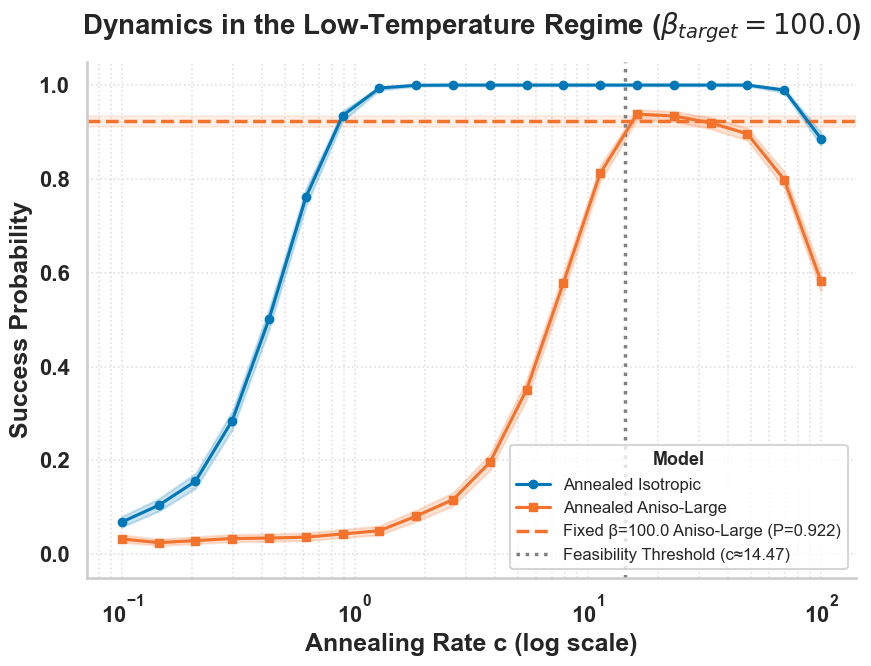

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from scipy.stats import norm
import seaborn as sns
import math


def create_figure_1b(
    saved_beta100_path,
    save_dir,
    precomputed_fixed_beta_path=None,
    beta_fixed=100.0,
    n_runs_fixed=2048,
):
    global key

    print("Loading and processing beta_target=100 results")
    try:
        with open(saved_beta100_path, 'r') as f: data = json.load(f)
        df = pd.DataFrame(data['results'])
        meta = data['meta']
    except FileNotFoundError as e:
        print(f"ERROR: Could not find result file: {e}. Please check path.")
        return
        
    df_iso = df[['c', 'n_runs', 'prob_iso']].copy()
    df_aniso = df[['c', 'n_runs', 'prob_aniso']].copy()

    df_iso['ci_lower'], df_iso['ci_upper'] = zip(*[wilson_score_interval(p, n) for p, n in zip(df_iso['prob_iso'], df_iso['n_runs'])])
    df_aniso['ci_lower'], df_aniso['ci_upper'] = zip(*[wilson_score_interval(p, n) for p, n in zip(df_aniso['prob_aniso'], df_aniso['n_runs'])])

    # Simulate or Load Fixed-Beta Baselines
    fixed_beta_results = None
    if precomputed_fixed_beta_path and os.path.exists(precomputed_fixed_beta_path):
        print(f"\nLoading pre-computed fixed-beta={beta_fixed} results from: {precomputed_fixed_beta_path}")
        with open(precomputed_fixed_beta_path, 'r') as f: fixed_beta_results = json.load(f)

    local_cache_file = os.path.join(save_dir, f"fixed_beta_{beta_fixed}_results.json")
    if fixed_beta_results is None and os.path.exists(local_cache_file):
        print(f"\nLoading cached fixed-beta={beta_fixed} results from: {local_cache_file}")
        with open(local_cache_file, 'r') as f: fixed_beta_results = json.load(f)

    if fixed_beta_results is None:
        print(f"\nNo cache found. Running fixed beta={beta_fixed} simulations ({n_runs_fixed} runs each)")
        
        simulation_steps_fixed = meta['max_steps']
        DT = meta['dt']
        DIM = meta['DIM']
        SUCCESS_THRESHOLD = meta['success_threshold']
        
        B_iso = jnp.eye(DIM)
        A_large = jnp.diag(jnp.array(meta['A_aniso_diag']))
        B_large = jnp.sqrt(A_large)

        models = {"Isotropic": B_iso, "Aniso-Large": B_large}
        fixed_beta_results = {}
        for name, B in models.items():
            keys = jax.random.split(key, n_runs_fixed + 1); run_keys, key = keys[:-1], keys[-1]
            final_Z = batch_simulate_fixed(run_keys, beta_fixed, simulation_steps_fixed, DT, B) 
            success_runs = jnp.sum(vmap(U0)(final_Z) < SUCCESS_THRESHOLD) 
            prob = float(success_runs) / n_runs_fixed
            ci_lower, ci_upper = wilson_score_interval(prob, n_runs_fixed)
            fixed_beta_results[name] = {"prob": prob, "ci": [ci_lower, ci_upper]}
            print(f"  Success Prob (Fixed Beta, {name}): {prob:.4f} (95% CI: [{ci_lower:.4f}, {ci_upper:.4f}])")
        
        with open(local_cache_file, 'w') as f: json.dump(fixed_beta_results, f, indent=4)
        print(f"Caching new results to: {local_cache_file}")

    print("\nGenerating plot for beta_target=100")
    sns.set_style("whitegrid"); sns.set_context("talk")
    fig, ax = plt.subplots(figsize=(9, 7))
    colors = {"iso": "#0077b6", "large": "#f3722c"}
    T_max = meta['max_steps'] * meta['dt']; beta_target = meta['beta_target']
    c_min_feasible = beta_target / math.log(T_max + 1.0)
    ax.plot(df_iso['c'], df_iso['prob_iso'], 'o-', label="Annealed Isotropic", color=colors['iso'], markersize=6, zorder=10)
    ax.fill_between(df_iso['c'], df_iso['ci_lower'], df_iso['ci_upper'], color=colors['iso'], alpha=0.2)
    ax.plot(df_aniso['c'], df_aniso['prob_aniso'], 's-', label="Annealed Aniso-Large", color=colors['large'], markersize=6, zorder=10)
    ax.fill_between(df_aniso['c'], df_aniso['ci_lower'], df_aniso['ci_upper'], color=colors['large'], alpha=0.2)
    res = fixed_beta_results["Aniso-Large"]
    prob_str = f"{res['prob']:.3f}"; label = f'Fixed β={beta_fixed} Aniso-Large (P={prob_str})'
    ax.axhline(y=res["prob"], color=colors['large'], linestyle='--', label=label, linewidth=2.5)
    ax.axhspan(res["ci"][0], res["ci"][1], color=colors['large'], alpha=0.1)
    ax.axvline(x=c_min_feasible, color='grey', linestyle=':', linewidth=2.5, label=f'Feasibility Threshold (c≈{c_min_feasible:.2f})')
    title_str = f"Dynamics in the Low-Temperature Regime ($\\beta_{{target}}={beta_target}$)"; ax.set_title(title_str, fontsize=20, fontweight='bold', pad=20)
    ax.set_xlabel("Annealing Rate c (log scale)", fontsize=18, fontweight='bold'); ax.set_ylabel("Success Probability", fontsize=18, fontweight='bold')
    ax.set_xscale("log"); ax.set_ylim(-0.05, 1.05)
    ax.tick_params(axis='both', which='major', labelsize=16)
    for label in ax.get_xticklabels() + ax.get_yticklabels(): label.set_fontweight('bold')
    ax.grid(True, which="both", linestyle=':', linewidth=1.2, alpha=0.6)
    legend = ax.legend(loc='best', fontsize=12, frameon=True, shadow=False, title="Model", title_fontsize=13)
    plt.setp(legend.get_title(), fontweight='bold')
    sns.despine(); plt.tight_layout()
    out_plot = os.path.join(save_dir, "figure_1b.png")
    plt.savefig(out_plot, dpi=300); print(f"\n[Success] Final plot for beta_target=100 saved to {out_plot}"); plt.show()

if __name__ == '__main__':
    PATH_TO_BETA100_RESULTS = 'anisotropic_experiments/experiment1/aniso_large_beta_100/results.json'
    PRECOMPUTED_CACHE_PATH_B100 = os.path.join("anisotropic_experiments", "experiment1", "fixed_beta_100_results.json")
    
    final_plot_dir = "./results/final_figures"
    os.makedirs(final_plot_dir, exist_ok=True)
    
    create_figure_1b(
        saved_beta100_path=PATH_TO_BETA100_RESULTS,
        save_dir=final_plot_dir,
        precomputed_fixed_beta_path=PRECOMPUTED_CACHE_PATH_B100,
        beta_fixed=100.0,
        n_runs_fixed=2048
    )

## Experiment 2: Distribution of Hitting Times

In [ ]:
def simulate_one_run_energy_history(key, c, n_steps, dt, B):
    """
    Returns an array of length n_steps with U0(Z_t) for t=1..n_steps.
    Accepts B, the matrix square root of the diffusion matrix A.
    """
    Z0 = renormalize(jax.random.normal(key, shape=(N_POINTS, DIM)))

    def step_fn(carry, t_idx):
        Z = carry
        t = t_idx * dt
        beta_t = c * jnp.log(t + 1.0)
        beta_t = jnp.maximum(beta_t, 1e-6)
        step_key = jax.random.fold_in(key, t_idx)
        drift = -grad_U0(Z) * dt
        dW_ambient = jax.random.normal(step_key, shape=Z.shape)
        dW_aniso = jnp.einsum("ij,bj->bi", B, dW_ambient)
        proj = batch_get_projection_matrix(Z)
        dW_tangent = jnp.einsum("bij,bj->bi", proj, dW_aniso)
        noise = dW_tangent * jnp.sqrt(2 * dt / beta_t)

        Z_new = renormalize(Z + drift + noise)
        energy_new = U0(Z_new)
        return Z_new, energy_new

    _, energy_hist = jax.lax.scan(step_fn, Z0, jnp.arange(n_steps))
    return energy_hist


batch_simulate_energy = jit(
    vmap(simulate_one_run_energy_history, in_axes=(0, None, None, None, None)),
    static_argnums=(2,)
)


def compute_stable_hitting_times(energy_histories, threshold, max_steps, stay_duration=5):
    """
    Computes the first time step where the energy drops below a threshold
    AND stays below it for `stay_duration` consecutive steps.
    """
    from scipy.signal import convolve

    hits = energy_histories < threshold

    # Use convolution to find consecutive hits. A run of `stay_duration` True values
    # will result in a value of `stay_duration` in the convolution output.
    kernel = jnp.ones(stay_duration)
    stable_hits = convolve(hits, kernel[None, :], mode='valid') >= stay_duration

    # Find the first index of a stable hit for each run
    first_stable_hit = jnp.argmax(stable_hits, axis=1)
    any_stable_hit = jnp.any(stable_hits, axis=1)

    # If a run never had a stable hit, its time is the max number of steps
    hitting_times = jnp.where(any_stable_hit, first_stable_hit, max_steps)
    return np.asarray(hitting_times)

def run_experiment_2_hitting_time(
    c_values,
    A_list,
    beta_target=40.0,
    dt=GLOBAL_CONFIG["dt"],
    max_steps=GLOBAL_CONFIG["max_steps"],
    n_runs=512,
    success_threshold=GLOBAL_CONFIG["success_threshold"],
    save_dir=SAVE_DIR,
    stay_duration=5,
    verbose=True
):
    """
    For each (c in c_values) and each A in A_list, run n_runs trajectories and compute hitting times.
    Saves CSV per combination and summary JSON + violin plot.
    """
    global key
    results_rows = []

    # create folder to store per-(c,A) files
    out_folder = os.path.join(save_dir, "experiment2_hitting_times")
    os.makedirs(out_folder, exist_ok=True)

    B_list = []
    for A in A_list:
        if A is None:  # Isotropic case
            B_list.append(jnp.eye(DIM))
        else:  # Anisotropic case
            B_list.append(jnp.sqrt(A))

    pbar_c = tqdm(c_values, desc="Exp2: c sweep", leave=True)
    for c in pbar_c:
        T_final = math.exp(beta_target / float(c)) - 1.0
        required_steps = int(min(math.ceil(T_final / dt), max_steps))

        keys = jax.random.split(key, n_runs + 1)
        run_keys, key = keys[:-1], keys[-1]

        for j, B in enumerate(B_list):
            A = A_list[j]  # Keep original A for logging/naming

            energy_hists = batch_simulate_energy(run_keys, c, required_steps, dt, B)
            energy_hists_np = np.asarray(energy_hists)

            hitting_times = compute_stable_hitting_times(energy_hists_np, success_threshold, required_steps, stay_duration)

            # save per-run CSV for this combination
            a_diag = "_".join([f"{float(x):.3g}" for x in jnp.diag(A)]) if A is not None else "isotropic"
            filename = os.path.join(out_folder, f"hitting_c{c:.3g}_A{a_diag}_steps{required_steps}_runs{n_runs}.npz")
            np.savez_compressed(filename, energy_hists=energy_hists_np, hitting_times=hitting_times)

            # append summary rows for each run 
            for run_idx, ht in enumerate(hitting_times):
                results_rows.append({
                    "c": float(c),
                    "A_idx": int(j),
                    "A_diag": a_diag,
                    "required_steps": int(required_steps),
                    "run_idx": int(run_idx),
                    "hitting_time_steps": int(ht),
                    "beta_reached": float(c * math.log(required_steps * dt + 1.0))
                })

            # quick summary print
            never_frac = np.mean(hitting_times >= required_steps)
            median_ht = np.median(hitting_times[hitting_times < required_steps]) if np.any(hitting_times < required_steps) else required_steps
            pbar_c.set_postfix_str(f"A={a_diag}, median_ht={median_ht:.1f}, never_hit={never_frac:.2%}")

    # Save a master csv of per-run results
    df = pd.DataFrame(results_rows)
    out_csv = os.path.join(save_dir, "experiment2_hitting_times_master.csv")
    df.to_csv(out_csv, index=False)

    cs_sorted = np.sort(np.unique(df["c"]))
    if len(cs_sorted) >= 3:
        rep_cs = [cs_sorted[0], cs_sorted[len(cs_sorted)//2], cs_sorted[-1]]
    else:
        rep_cs = list(cs_sorted)

    plt.style.use("seaborn-v0_8-whitegrid")
    for c_rep in rep_cs:
        df_subset = df[df["c"] == c_rep]
        plt.figure(figsize=(10,6))
        sns.violinplot(data=df_subset, x="A_diag", y="hitting_time_steps", cut=0)
        plt.yscale("log")
        plt.title(f"Hitting Time Distribution (c={c_rep:.3g})")
        plt.xlabel("Noise model (A diag)")
        plt.ylabel("Hitting time (steps) [log scale]")
        plt.tight_layout()
        out_plot = os.path.join(save_dir, f"exp2_violin_c{c_rep:.3g}.png")
        plt.savefig(out_plot, dpi=300)
        plt.show()

    # Also produce ECDF plot for a chosen A (e.g., hardest A, last in list)
    chosen_A_idx = len(A_list)-1
    df_A = df[df["A_idx"] == chosen_A_idx]
    plt.figure(figsize=(8,6))
    for c_val in np.unique(df_A["c"]):
        subset = df_A[df_A["c"] == c_val]["hitting_time_steps"].values
        # compute empirical CDF
        xs = np.sort(subset)
        ys = np.arange(1, len(xs)+1) / len(xs)
        plt.step(xs, ys, where='post', label=f"c={c_val:.3g}", alpha=0.7)
    plt.xscale("log")
    plt.xlabel("Hitting time (steps) [log scale]")
    plt.ylabel("ECDF")
    plt.title(f"ECDF of hitting times for A_idx={chosen_A_idx}")
    plt.legend()
    out_ecdf = os.path.join(save_dir, f"exp2_ecdf_A{chosen_A_idx}.png")
    plt.savefig(out_ecdf, dpi=300)
    plt.show()

    # Save summary JSON
    summary = {
        "n_runs": int(n_runs),
        "beta_target": float(beta_target),
        "dt": float(dt),
        "max_steps": int(max_steps),
        "success_threshold": float(success_threshold),
        "A_list_diags": [list(map(float, jnp.diag(A))) if A is not None else "isotropic" for A in A_list]
    }
    out_summary = os.path.join(save_dir, "experiment2_summary.json")
    with open(out_summary, "w") as f:
        json.dump(summary, f, indent=2)

    print(f"[Done] Experiment 2 saved to {out_folder}, master CSV: {out_csv}, summary: {out_summary}")
    return df


In [ ]:
final_A_list = [
    None, 
    jnp.diag(jnp.array([10.0, 10.0, 0.01])), 
    jnp.diag(jnp.array([20.0, 20.0, 10.01])),
    jnp.diag(jnp.array([1.0, 1.0, 0.01]))
]

df_final_ht = run_experiment_2_hitting_time(
    c_values=np.logspace(np.log10(0.1), np.log10(100), 4),
    A_list=final_A_list,
    beta_target=10.0,
    n_runs=512,
    stay_duration=5, 
    success_threshold=1e-4
)

Exp2: c sweep:   0%|          | 0/4 [10:04:58<?, ?it/s, A=20_20_10, median_ht=21384.5, never_hit=0.00%]

### Experiment 2 plotting

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

def analyze_hitting_time_stats_full(csv_path):
    """
    Loads hitting time data and computes a full set of summary statistics,
    including measures of shape (skew, kurtosis).
    """
    print(f"Loading data from: {csv_path}")
    if not os.path.exists(csv_path):
        print(f"Error: File not found at {csv_path}")
        return

    df = pd.read_csv(csv_path)

    grouped = df.groupby(['c', 'A_diag'])

    summary = grouped['hitting_time_steps'].agg(
        mean='mean',
        median='median',
        skew='skew',
        kurtosis=lambda x: x.kurtosis(),
        p25=lambda x: x.quantile(0.25),
        p75=lambda x: x.quantile(0.75),
        p95=lambda x: x.quantile(0.95)
    ).reset_index()

    summary['IQR'] = summary['p75'] - summary['p25']

    def failure_rate(group):
        failed_runs = group['hitting_time_steps'] >= group['required_steps']
        return failed_runs.mean() * 100

    failures = grouped.apply(failure_rate).rename('Failure Rate (%)').reset_index()

    final_summary = pd.merge(summary, failures, on=['c', 'A_diag'])
    final_summary = final_summary[[
        'c', 'A_diag', 'mean', 'median', 'skew', 'kurtosis',
        'IQR', 'p95', 'Failure Rate (%)'
    ]]

    print("\n Full Summary Statistics for Hitting Times")
    with pd.option_context('display.max_rows', None, 'display.width', 120):
        print(final_summary.to_string(index=False, float_format="%.2f"))

    return final_summary


def create_figure_2(
    csv_path,
    save_dir,
    c_values_to_plot=[0.1, 1.0],
):
    print(f" Generating Figure 2 from: {csv_path}")
    if not os.path.exists(csv_path):
        print(f"ERROR: File not found at {csv_path}")
        return

    df = pd.read_csv(csv_path)
    os.makedirs(save_dir, exist_ok=True)

    diag_labels = df['A_diag'].unique()
    label_map = {'isotropic': 'Isotropic'}
    # Identify the two anisotropic labels
    aniso_labels = [l for l in diag_labels if l != 'isotropic']
    if len(aniso_labels) == 2:
        sum1 = sum(map(float, aniso_labels[0].split('_')))
        sum2 = sum(map(float, aniso_labels[1].split('_')))
        
        if sum1 > sum2:
            label_map[aniso_labels[0]] = 'Aniso-Large'
            label_map[aniso_labels[1]] = 'Aniso-Small'
        else:
            label_map[aniso_labels[0]] = 'Aniso-Small'
            label_map[aniso_labels[1]] = 'Aniso-Large'
    elif len(aniso_labels) == 1:
        print(f"Warning: Only one anisotropic model found: {aniso_labels[0]}")
        # todo: better logic for determining aniso labelling
        if '20' in aniso_labels[0]:
             label_map[aniso_labels[0]] = 'Aniso-Large'
        else:
             label_map[aniso_labels[0]] = 'Aniso-Small'

    print("Detected and mapped labels:", label_map)
            
    df['Model'] = df['A_diag'].map(label_map)
    
    df_filtered = df[df['c'].isin(c_values_to_plot)]
    model_order = ['Isotropic', 'Aniso-Small', 'Aniso-Large']
    
    sns.set_style("whitegrid")
    sns.set_context("talk")
    fig, axes = plt.subplots(1, len(c_values_to_plot), figsize=(14, 7), sharey=True)
    if len(c_values_to_plot) == 1: axes = [axes]

    colors = {"Isotropic": "#2ecc71", "Aniso-Small": "#3498db", "Aniso-Large": "#e74c3c"}
    
    # Generate a Violin Plot on Each Subplot
    for i, c_val in enumerate(c_values_to_plot):
        ax = axes[i]
        df_subset = df_filtered[df_filtered['c'] == c_val]

        sns.violinplot(
            data=df_subset,
            x="Model",
            y="hitting_time_steps",
            ax=ax,
            cut=0,
            order=model_order,
            palette=colors
        )

        ax.set_yscale('log')
        if c_val < 0.5: title = f"c = {c_val} (Slow Schedule)"
        elif c_val < 5: title = f"c = {c_val} (Medium Schedule)"
        else: title = f"c = {c_val} (Fast Schedule)"
        ax.set_title(title, fontsize=18, fontweight='bold')
        ax.set_xlabel("Noise Model", fontsize=16, fontweight='bold')
        ax.tick_params(axis='x', labelsize=14)
        ax.tick_params(axis='y', labelsize=14)
        for label in ax.get_xticklabels() + ax.get_yticklabels():
            label.set_fontweight('bold')
        
    axes[0].set_ylabel("Hitting Time Steps (log scale)", fontsize=18, fontweight='bold')
    fig.suptitle("Hitting Time Distribution vs. Annealing Rate", fontsize=20, fontweight='bold')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    sns.despine(fig)

    output_filename = os.path.join(save_dir, "figure_2_hitting_times.png")
    plt.savefig(output_filename, dpi=300)
    print(f"Final Figure 2 saved to {output_filename}")
    plt.show()


if __name__ == '__main__':
    PATH_TO_CSV = 'anisotropic_experiments/experiment2/experiment2_hitting_times_master.csv'
    FINAL_FIGURE_DIR = "./results/final_figures"
    
    create_figure_2(
        csv_path=PATH_TO_CSV,
        save_dir=FINAL_FIGURE_DIR,
        c_values_to_plot=[0.1, 1.0]
    )
    analyze_hitting_time_stats_full(csv_path=PATH_TO_CSV)

### Fixed Hitting Times

In [ ]:
def simulate_one_run_fixed_beta_hitting_time(key, beta_fixed, n_steps, dt, B, threshold, stay_duration):
    Z_init = renormalize(random.normal(key, shape=(N_POINTS, DIM)))
    NOT_FOUND = n_steps; carry_init = (Z_init, NOT_FOUND, 0)
    def step_fn(carry, t_idx):
        Z, hitting_time, consecutive_hits = carry
        def update_state():
            step_key = random.fold_in(key, t_idx); drift = -grad_U0(Z) * dt
            dW_ambient = random.normal(step_key, shape=Z.shape); dW_aniso = jnp.einsum("ij,bj->bi", B, dW_ambient)
            proj = batch_get_projection_matrix(Z); dW_tangent = jnp.einsum("bij,bj->bi", proj, dW_aniso)
            noise = dW_tangent * jnp.sqrt(2 * dt / beta_fixed); Z_new = renormalize(Z + drift + noise)
            energy_new = U0(Z_new); is_below = energy_new < threshold
            new_consecutive = lax.select(is_below, consecutive_hits + 1, 0)
            just_hit_stably = (new_consecutive == stay_duration); time_of_hit = t_idx - stay_duration + 1
            new_hitting_time = lax.select(just_hit_stably, time_of_hit, NOT_FOUND)
            return (Z_new, new_hitting_time, new_consecutive)
        def pass_through_state(): return carry
        return lax.cond(hitting_time == NOT_FOUND, update_state, pass_through_state), None
    final_carry, _ = lax.scan(step_fn, carry_init, jnp.arange(n_steps))
    return final_carry[1]

batch_simulate_fixed_hitting_time = jit(
    vmap(simulate_one_run_fixed_beta_hitting_time, in_axes=(0, None, None, None, None, None, None)),
    static_argnums=(2, 5, 6)
)


def get_fixed_beta_hitting_time_stats(
    beta_fixed=10.0,
    n_runs=2048,
    simulation_steps=50000,
    stay_duration=5
):
    """
    Runs simulations for fixed beta and prints a full summary statistics table.
    """
    global key
    A_small = jnp.diag(jnp.array([1.0, 1.0, 0.1]))
    A_large = jnp.diag(jnp.array([20.0, 20.0, 10.0]))
    models = {
        "Isotropic": jnp.eye(DIM),
        "Aniso-Small": jnp.sqrt(A_small),
        "Aniso-Large": jnp.sqrt(A_large)
    }
    
    all_results = []
    print(f" Running Fixed Beta={beta_fixed} Hitting Time Simulations")
    
    for name, B in tqdm(models.items(), desc="Simulating Models"):
        run_keys = random.split(key, n_runs)
        key = random.fold_in(key, n_runs)
        
        hitting_times = batch_simulate_fixed_hitting_time(
            run_keys, beta_fixed, simulation_steps, DT, B, SUCCESS_THRESHOLD, stay_duration
        )
        # Store all individual hitting times for later analysis
        for ht in np.asarray(hitting_times):
            all_results.append({"Model": name, "hitting_time": int(ht)})

    df_full = pd.DataFrame(all_results)
    
    grouped = df_full.groupby('Model')
    
    summary = grouped['hitting_time'].agg(
        mean='mean',
        median='median',
        skew='skew',
        kurtosis=lambda x: x.kurtosis(),
        p25=lambda x: x.quantile(0.25),
        p75=lambda x: x.quantile(0.75),
        p95=lambda x: x.quantile(0.95)
    ).reset_index()

    summary['IQR'] = summary['p75'] - summary['p25']

    def failure_rate(group):
        # All runs in a group have the same max_steps
        failed_runs = group['hitting_time'] >= simulation_steps
        return failed_runs.mean() * 100

    failures = grouped.apply(failure_rate).rename('Failure Rate (%)').reset_index()
    
    final_summary = pd.merge(summary, failures, on='Model')

    final_summary = final_summary[[
        'Model', 'mean', 'median', 'skew', 'kurtosis', 'IQR', 'p95', 'Failure Rate (%)'
    ]]
    
    # Ensure the models are in a consistent order for printing
    model_order = ["Isotropic", "Aniso-Small", "Aniso-Large"]
    final_summary['Model'] = pd.Categorical(final_summary['Model'], categories=model_order, ordered=True)
    final_summary = final_summary.sort_values('Model')

    print(f"\n Full Summary Statistics for Fixed Beta={beta_fixed} Hitting Times")
    with pd.option_context('display.max_rows', None, 'display.width', 120):
        print(final_summary.to_string(index=False, float_format="%.2f"))
        
    return final_summary

if __name__ == '__main__':
    print(" Calculating stats for beta=10.0")
    fixed_beta_10_summary = get_fixed_beta_hitting_time_stats(beta_fixed=10.0)
    
    print("\n\n Calculating stats for beta=100.0")
    fixed_beta_100_summary = get_fixed_beta_hitting_time_stats(beta_fixed=100.0)